---

# University of Liverpool

## COMP534 - Applied AI

---

This notebook is associated with Assignment 3. Use it to complete the assignment by following the instructions provided in each section. Each section includes a text cell outlining the requirements. For additional details, refer to Canvas.

Use this first cell to import the necessary libraries.

In [527]:
import copy
import torch
import math
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.utils.data as data
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split


# 1. **Data Management**


In this part, you need to:

1.  define your experimental protocol (such as k-fold, cross validation, etc);
2.	create the dataloader to load the data.



In [528]:
def read_data(file_path):
    sentences = []
    current_sentence = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                if current_sentence:
                    sentences.append(current_sentence)
                    current_sentence = []
            else:
                parts = line.split(' ', 1)  # Split into word and tag
                if len(parts) == 2:
                    word, tag = parts
                    if word not in string.punctuation:
                        current_sentence.append((word, tag))
        if current_sentence:
            sentences.append(current_sentence)
    return sentences


def build_vocab(sentences):
    word_counts = {}
    for sentence in sentences:
        for word, tag in sentence:
            word_counts[word] = word_counts.get(word, 0) + 1
    word_to_ix = {'<PAD>': 0, '<UNK>': 1}
    for word in word_counts:
        word_to_ix[word] = len(word_to_ix)
    return word_to_ix


class NERDataset(data.Dataset):
    def __init__(self, sentences, word_to_ix, tag_to_ix):
        self.sentences = sentences
        self.word_to_ix = word_to_ix
        self.tag_to_ix = tag_to_ix

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        word_indices = [self.word_to_ix.get(word, self.word_to_ix['<UNK>']) for word, _ in sentence]
        tag_indices = [self.tag_to_ix[tag] for _, tag in sentence]
        return torch.tensor(word_indices, dtype=torch.long), torch.tensor(tag_indices, dtype=torch.long)


def collate_fn(batch):
    inputs, targets = zip(*batch)
    inputs_padded = pad_sequence(inputs, batch_first=True, padding_value=0)
    targets_padded = pad_sequence(targets, batch_first=True, padding_value=-100)
    return inputs_padded, targets_padded


In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Read all sentences
file_path = "ner_dataset.txt"
sentences = read_data(file_path)

# Split into kfold-set (80%), test (20%)
train_sentences, test_sentences = train_test_split(sentences, test_size=0.2,
                                                   random_state=42)


# Create vocabs
tag_to_ix = {'O': 0, 'I-LOC': 1, 'I-PER': 2, 'I-ORG': 3, 'I-MISC': 4}
word_to_ix = build_vocab(train_sentences)

# Create test dataset
test_dataset = NERDataset(test_sentences, word_to_ix, tag_to_ix)

# prepare our k-fold
k = 5
batch_size = 16
kf = KFold(k, shuffle=True, random_state=42)

# Create test dataloader
test_dataloader = data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn
)




---

# 2. **Neural Networks**

Here, you need to:

1.	create a Recurrent Neural Network (RNN) (such as RNN, GRU, LSTM) to tackle the problem;
2.	create a Transformer Network to tackle the problem;
3.	define the necessary components to train the networks (that is, loss function, optimizers, etc);
4.	train the models;
5.	for all training procedures, separately plot the loss and accuracy with respect to the epoch/iteration.

Bidirectional LSTM

In [530]:
# Define our BiLSTM

class BiLSTM(nn.Module):
    #define the parent Model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=1, dropout=0.3):
        super(BiLSTM,self).__init__()
        # Embedding layer to convert word indices to vectors
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # BiLSTM layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, bidirectional=True, batch_first=True)
        # Fully connected layer to map to output dimensions (*2 -- bidirectional)
        self.fc = nn.Linear(hidden_dim * 2, output_dim) 
        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout)

    # Define the forward pass
    def forward(self, x):
        # Embed the input and apply dropout
        embedded = self.dropout(self.embedding(x))
        # Pass through the BiLSTM
        lstm_out, _ = self.lstm(embedded) 
        # Apply dropout to the LSTM output
        lstm_out = self.dropout(lstm_out)
        # Pass through the fully connected layer to get logits
        logits = self.fc(lstm_out)
        return logits.view(-1,5)
    

**Transformer**

In [531]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        # Ensure that the model dimension (d_model) is divisible by the number of heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        # Initialize dimensions
        self.d_model = d_model # Model's dimension
        self.num_heads = num_heads # Number of attention heads
        self.d_k = d_model // num_heads # Dimension of each head's key, query, and value
        
        # Linear layers for transforming inputs
        self.W_q = nn.Linear(d_model, d_model) # Query transformation
        self.W_k = nn.Linear(d_model, d_model) # Key transformation
        self.W_v = nn.Linear(d_model, d_model) # Value transformation
        self.W_o = nn.Linear(d_model, d_model) # Output transformation
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Calculate attention scores
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        # Apply mask if provided (useful for preventing attention to certain parts like padding)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        
        # Softmax is applied to obtain attention probabilities
        attn_probs = torch.softmax(attn_scores, dim=-1)
        
        # Multiply by values to obtain the final output
        output = torch.matmul(attn_probs, V)
        return output
        
    def split_heads(self, x):
        # Reshape the input to have num_heads for multi-head attention
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)
        
    def combine_heads(self, x):
        # Combine the multiple heads back to original shape
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        
    def forward(self, Q, K, V, mask=None):
        # Apply linear transformations and split heads
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        
        # Perform scaled dot-product attention
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        
        # Combine heads and apply output transformation
        output = self.W_o(self.combine_heads(attn_output))
        return output


class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))
    
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()
        
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]
    
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x
    

class TransformerNER(nn.Module):
    def __init__(self, vocab_size, tagset_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout, pad_idx=0):
        super(TransformerNER, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=pad_idx)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])

        self.fc = nn.Linear(d_model, tagset_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        # Create padding mask: shape [batch, 1, 1, seq_len]
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)

        x = self.embedding(src)
        x = self.positional_encoding(x)
        x = self.dropout(x)

        for layer in self.encoder_layers:
            x = layer(x, src_mask)

        output = self.fc(x)
        return output.view(-1,5)

In [532]:
# Define an accuracy function to deal with the padded values
def masked_accuracy(y_true, y_pred):
    # Create the mask, i.e., the values that will be ignored
    mask = (y_true != -100)

    # Compare the true values with the predicted ones
    matches_true_pred = [a == p for a,p in zip(y_true,y_pred) if p != -100]

    # Compute masked accuracy (quotient between the total matches and the total valid values, i.e., the amount of non-masked values)
    masked_acc = sum(matches_true_pred) / np.sum(mask)
    
    return masked_acc


In [533]:
# Define a training loop
def train(dataloader, model, criterion, optimizer, epoch):
    model.train()
    for sentences, labels in dataloader:
        optimizer.zero_grad()
        output = model(sentences)
        loss = criterion(output, labels.view(-1))
        loss.backward()
        optimizer.step()
    acc = masked_accuracy(labels.view(-1).numpy(), output.argmax(dim=-1).cpu().numpy())
    print(f"TRAIN -- Epoch {epoch+1}, Loss: {loss.item():.4f}, Masked Accuracy: {acc:.4f}")
    return acc, loss.item()

def validation(dataloader, model):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for sentences, labels in dataloader:
            output = model(sentences)
            all_preds.append(output.argmax(dim=-1).cpu().numpy())
            all_labels.append(labels.view(-1).cpu().numpy())

        all_preds = np.concatenate(all_preds, axis=0)
        all_labels = np.concatenate(all_labels, axis=0)

        acc = masked_accuracy(all_labels, all_preds)
        print(f"VAL -- Masked Accuracy: {acc}")
    return acc

# Define a function to plot the loss curve
def plot_loss(model_name, train_losses):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    for i, acc in enumerate(train_losses):
        plt.plot(acc, label=f'Fold{i+1}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Training Loss for {model_name}')

    plt.show()


# Define a function to plot the accuracy curve
def plot_acc(model_name, train_accuracies, val_accuracies):
    plt.subplot(1, 2, 2)
    for i, acc in enumerate(train_accuracies):
        plt.plot(acc, label=f'Train acc, Fold{i+1}')
    for i, acc in enumerate(val_accuracies):
        plt.plot(acc, label=f'Val acc, Fold{i+1}', linestyle='dashed')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title(f'Training vs Validation Accuracy for {model_name}')

    plt.show()

# Loop for training, evaluating and plotting
def train_plots(model, model_name, criterion, optimizer, train_data, num_epochs=50):
    results_val_acc = []
    val_acc_hist = [] 
    train_loss_hist = [] 
    train_acc_hist = []
    
    base_model = model

    overall_best_acc = 0
    overall_best_model = model
    initial_opt = optimizer

    for fold, (train_idx, val_idx) in enumerate(kf.split(train_data)):
        print(f'\n--- FOLD: {fold+1}/{k} ---')
        
        model = base_model
    
        train_losses = []
        train_accuracies = []
        val_accuracies = []

        train_sentences = [sentences[i] for i in train_idx]
        val_sentences = [sentences[i] for i in val_idx]

        train_dataset = NERDataset(train_sentences, word_to_ix, tag_to_ix)
        val_dataset = NERDataset(val_sentences, word_to_ix, tag_to_ix)

        train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
        val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

        best_model = model
        best_acc = 0

        # Implement LR Scheduler
        optimizer = initial_opt
        scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=30)

        for epoch in range(num_epochs):
            acc, loss = train(train_dataloader, model, criterion, optimizer,epoch)
            train_losses.append(loss)
            train_accuracies.append(acc)
            v_acc = validation(val_dataloader, model)
            val_accuracies.append(v_acc)
            scheduler.step()

            if v_acc > best_acc:
                best_model = copy.deepcopy(model)
                best_acc = v_acc
        
        results_val_acc.append(best_acc)
    
        if best_acc > overall_best_acc:
            overall_best_model = copy.deepcopy(best_model)
            overall_best_acc = best_acc
        
        train_acc_hist.append(train_accuracies)
        train_loss_hist.append(train_losses)
        val_acc_hist.append(val_accuracies)
    
    plot_loss(model_name, train_loss_hist)
    plot_acc(model_name, train_acc_hist, val_acc_hist)

    avg_acc = np.avg(results_val_acc)
    print(f'best accuracy per fold {results_val_acc}')
    print(f'avg overall accuracy: {avg_acc}')

    return overall_best_model, avg_acc


In [534]:
# Train and validate models 

# Parameters
vocab_size = len(word_to_ix) # vocab size from word_to_ix
embedding_dim = len(max(sentences, key=len)) # largest dimension of word embeddings
output_dim = len(tag_to_ix)  # number of unique tags

# Hyperparam for LSTM
hidden_dim = 128  # hidden dimension of LSTM

# Hyper params for Transformer
d_model = 128                      # smaller embedding size (128 is common)
num_heads = 4                        # fewer heads since model is smaller
num_layers = 2                        # 2 encoder layers is sufficient
d_ff = 256                            # feedforward layer size
dropout = 0.1                         # regularization to prevent overfitting


In [535]:
# Loop for training, evaluating and plotting
def train_plots(model_name, train_data, num_epochs=25):
    results_val_acc = []
    results_train_acc = []
    val_acc_hist = [] 
    train_loss_hist = [] 
    train_acc_hist = []


    overall_best_acc = 0
    overall_best_model = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(train_data)):
        print(f'\n--- FOLD: {fold+1}/{k} ---')
        
        if model_name == 'BiLSTM':
            model = BiLSTM(vocab_size, embedding_dim, hidden_dim, output_dim)
            criterion = nn.CrossEntropyLoss(ignore_index = -100)  
            optimizer = optim.Adam(model.parameters(), lr=0.01)

        else:
            model = TransformerNER(vocab_size, output_dim, d_model, num_heads, num_layers, d_ff, embedding_dim, dropout)
            criterion = nn.CrossEntropyLoss(ignore_index=-100)
            optimizer = optim.Adam(model.parameters(), lr=0.001)
    
        train_losses = []
        train_accuracies = []
        val_accuracies = []

        train_sentences = [sentences[i] for i in train_idx]
        val_sentences = [sentences[i] for i in val_idx]

        train_dataset = NERDataset(train_sentences, word_to_ix, tag_to_ix)
        val_dataset = NERDataset(val_sentences, word_to_ix, tag_to_ix)

        train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
        val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

        best_model = model
        best_acc = 0
        best_val_acc = 0

        # Implement LR Scheduler
        scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=30)

        for epoch in range(num_epochs):
            acc, loss = train(train_dataloader, model, criterion, optimizer,epoch)
            train_losses.append(loss)
            train_accuracies.append(acc)
            v_acc = validation(val_dataloader, model)
            val_accuracies.append(v_acc)
            scheduler.step()

            if v_acc > best_val_acc:
                best_model = copy.deepcopy(model)
                best_val_acc = v_acc
            
            if acc > best_acc:
                best_acc = acc
        
        results_val_acc.append(best_val_acc)
        results_train_acc.append(best_acc)
    
        if best_val_acc > overall_best_acc:
            overall_best_model = copy.deepcopy(best_model)
            overall_best_acc = best_val_acc
        
        train_acc_hist.append(train_accuracies)
        train_loss_hist.append(train_losses)
        val_acc_hist.append(val_accuracies)
    
    plot_loss(model_name, train_loss_hist)
    plot_acc(model_name, train_acc_hist, val_acc_hist)

    avg_val_acc = sum(results_val_acc)/len(results_val_acc)
    print(f'best validation accuracy per fold {results_val_acc}')
    print(f'avg overall validation accuracy: {avg_val_acc}')

    avg_acc = sum(results_train_acc)/len(results_train_acc)
    print(f'best train accuracy per fold {results_train_acc}')
    print(f'avg overall train accuracy: {avg_acc}')
    return overall_best_model, avg_val_acc



--- FOLD: 1/5 ---
TRAIN -- Epoch 1, Loss: 0.4232, Masked Accuracy: 0.8727
VAL -- Masked Accuracy: 0.8445877163216831
TRAIN -- Epoch 2, Loss: 0.3282, Masked Accuracy: 0.8919
VAL -- Masked Accuracy: 0.8814048184594503
TRAIN -- Epoch 3, Loss: 0.3271, Masked Accuracy: 0.8986
VAL -- Masked Accuracy: 0.8926026467594164
TRAIN -- Epoch 4, Loss: 0.0919, Masked Accuracy: 0.9721
VAL -- Masked Accuracy: 0.8953172718018324
TRAIN -- Epoch 5, Loss: 0.2001, Masked Accuracy: 0.9466
VAL -- Masked Accuracy: 0.8971835765184933
TRAIN -- Epoch 6, Loss: 0.0990, Masked Accuracy: 0.9562
VAL -- Masked Accuracy: 0.8995588734306074
TRAIN -- Epoch 7, Loss: 0.0455, Masked Accuracy: 0.9832
VAL -- Masked Accuracy: 0.9038004750593824
TRAIN -- Epoch 8, Loss: 0.0721, Masked Accuracy: 0.9751
VAL -- Masked Accuracy: 0.9014251781472684
TRAIN -- Epoch 9, Loss: 0.1522, Masked Accuracy: 0.9345
VAL -- Masked Accuracy: 0.9038004750593824
TRAIN -- Epoch 10, Loss: 0.0395, Masked Accuracy: 0.9875
VAL -- Masked Accuracy: 0.9029521

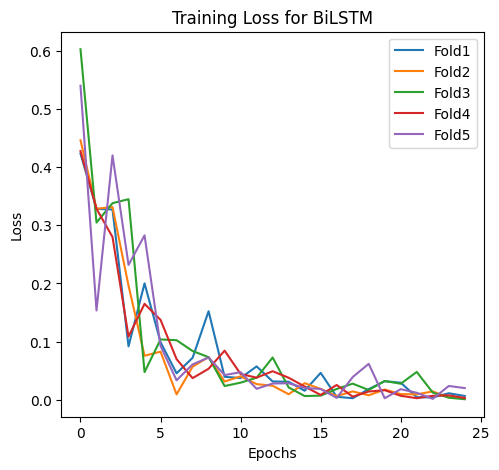

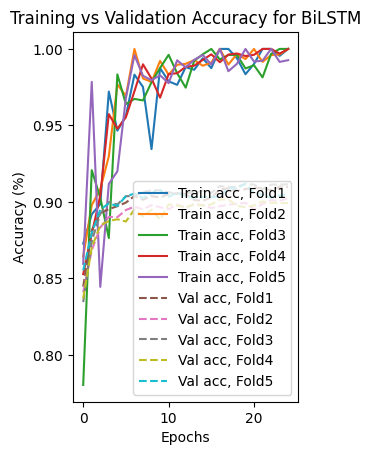

best validation accuracy per fold [0.9099083814048184, 0.9022421524663677, 0.911683021662655, 0.9016273541780947, 0.9119853613906679]
avg overall validation accuracy: 0.9074892542205207
best train accuracy per fold [1.0, 1.0, 1.0, 1.0, 1.0]
avg overall train accuracy: 1.0

--- FOLD: 1/5 ---
TRAIN -- Epoch 1, Loss: 0.5787, Masked Accuracy: 0.8670
VAL -- Masked Accuracy: 0.8196470987444859
TRAIN -- Epoch 2, Loss: 0.4141, Masked Accuracy: 0.9153
VAL -- Masked Accuracy: 0.824058364438412
TRAIN -- Epoch 3, Loss: 0.4518, Masked Accuracy: 0.8773
VAL -- Masked Accuracy: 0.843909060061079
TRAIN -- Epoch 4, Loss: 0.2964, Masked Accuracy: 0.9091
VAL -- Masked Accuracy: 0.8518832711231761
TRAIN -- Epoch 5, Loss: 0.3582, Masked Accuracy: 0.8791
VAL -- Masked Accuracy: 0.8656260604004072
TRAIN -- Epoch 6, Loss: 0.1876, Masked Accuracy: 0.9249
VAL -- Masked Accuracy: 0.8678316932473702
TRAIN -- Epoch 7, Loss: 0.1560, Masked Accuracy: 0.9463
VAL -- Masked Accuracy: 0.8702069901594842
TRAIN -- Epoch 8,

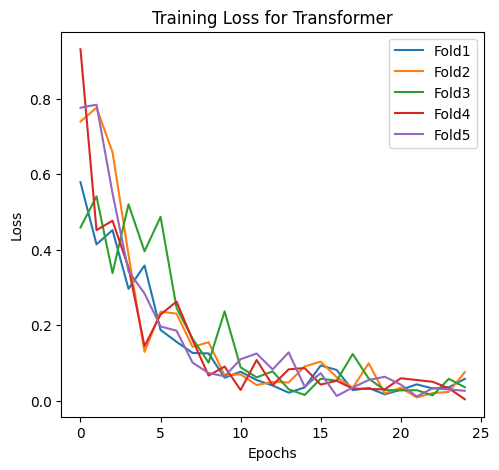

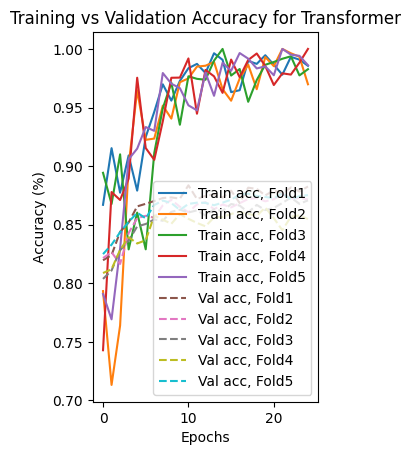

best validation accuracy per fold [0.8836104513064132, 0.8760538116591928, 0.8731716348824292, 0.8646918997988663, 0.8768526989935956]
avg overall validation accuracy: 0.8748760993280994
best train accuracy per fold [0.9963235294117647, 1.0, 1.0, 1.0, 1.0]
avg overall train accuracy: 0.9992647058823529


In [536]:
BiLSTM_NER, LSTM_acc = train_plots('BiLSTM', train_sentences)

transformer, transformer_acc = train_plots('Transformer', train_sentences)

---

# 3. **Evaluate models**

Here, you need to:

1.	evaluate the model (the best ones you obtained in the above stage).


results of our final model: BiLSTM
Overall Accuracy: 97.20%


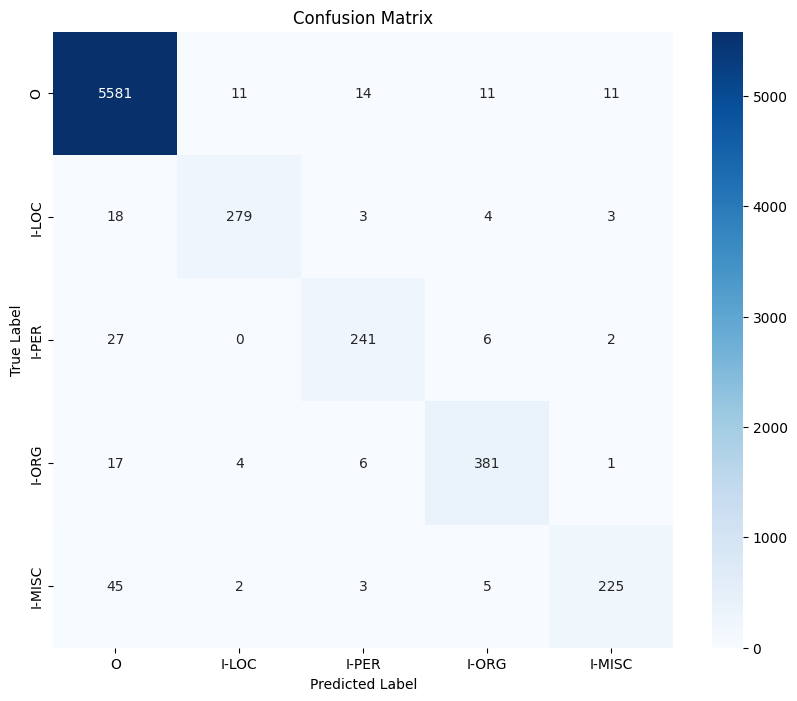

              precision    recall  f1-score      support
O              0.981188  0.991649  0.986391  5628.000000
I-LOC          0.942568  0.908795  0.925373   307.000000
I-PER          0.902622  0.873188  0.887661   276.000000
I-ORG          0.936118  0.931540  0.933824   409.000000
I-MISC         0.929752  0.803571  0.862069   280.000000
accuracy       0.972029  0.972029  0.972029     0.972029
macro avg      0.938450  0.901749  0.919064  6900.000000
weighted avg   0.971569  0.972029  0.971566  6900.000000


In [538]:
# Function to evaluate the model and generate reports
def evaluate_model_with_metrics(model, test_loader, class_names, model_name):
    model.eval()
    all_preds = []
    all_labels = []
    
    print(f"results of our final model: {model_name}")
    with torch.no_grad():
        for sentences, labels in test_loader:
            output = model(sentences)

            all_preds.append(output.argmax(dim=-1).cpu().numpy())
            all_labels.append(labels.view(-1).cpu().numpy())

        all_preds = np.concatenate(all_preds, axis=0)
        all_labels = np.concatenate(all_labels, axis=0)

        # remove padding values
        all_preds = np.delete(all_preds, np.where(all_labels == -100))
        all_labels = np.delete(all_labels, np.where(all_labels == -100))

    # Compute the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Generate classification report
    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    overall_accuracy = report['accuracy']
    print(f'Overall Accuracy: {overall_accuracy * 100:.2f}%')
    
    # Convert classification report to DataFrame
    df_report = pd.DataFrame(report).transpose()
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()
    
    return df_report

# Find the best model and call the function
if LSTM_acc > transformer_acc:
    final_model = BiLSTM_NER
    model_name = 'BiLSTM'
else:
    final_model = transformer
    model_name = 'Transformer'

df_results = evaluate_model_with_metrics(final_model, test_dataloader, tag_to_ix.keys(), model_name)

# Display results table
print(df_results)
